# Transfer learning / fine-tuning




In [3]:
!pip install hyperas

In [4]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation,GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [5]:
import time

In [6]:
import numpy as np
from hyperopt import Trials, STATUS_OK, tpe
from keras.datasets import mnist
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils
from hyperas import optim
from hyperas.distributions import choice, uniform

## getting dataset.

In [7]:
!rm -r -f muestras muestras.rar
# !wget https://gitlab.com/daquesada/tranfer-learning/-/raw/main/muestras.rar
# !wget -O muestras.rar https://gitlab.com/daquesada/tranfer-learning/-/raw/main/muestras_C14.rar
# !wget -O muestras.rar https://gitlab.com/daquesada/tranfer-learning/-/raw/main/muestras_C19.rar
!wget -O muestras.rar https://gitlab.com/daquesada/tranfer-learning/-/raw/main/muestras_C19_fix.rar

--2022-03-26 21:27:14--  https://gitlab.com/daquesada/tranfer-learning/-/raw/main/muestras_C19_fix.rar
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 320012048 (305M) [application/x-rar-compressed]
Saving to: ‘muestras.rar’

muestras.rar        100%[===================>] 305.19M   319MB/s    in 1.0s    

2022-03-26 21:27:16 (319 MB/s) - ‘muestras.rar’ saved [320012048/320012048]



In [8]:
!unzip  muestras.zip

Archive:  muestras.zip
  inflating: muestras/test/a16-AceiteMario/SingleShot0085.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0086.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0087.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0088.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0089.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0090.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0091.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0092.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0093.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0094.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0095.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0096.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0097.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0098.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0099.jpg  
  inflating: mues

# Utils

In [9]:
import tensorflow as tf
from tensorflow.keras import layers
resize_and_rescale = tf.keras.Sequential([layers.RandomFlip("vertical"),
  layers.RandomRotation(0.2),layers.RandomZoom(-1)])

2022-03-26 21:27:32.443368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 21:27:32.587178: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 21:27:32.587937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 21:27:32.589438: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

This function is useful for pre-processing the data into an image and input vector.

In [10]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

load all data from root file

In [11]:
def load_data(categories):
  data = []
  for c, category in enumerate(categories):
      images = [os.path.join(dp, f) for dp, dn, filenames 
                in os.walk(category) for f in filenames 
                if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
      for img_path in images:
          img, x = get_image(img_path)
          result_flip = resize_and_rescale(x[0])
          result_rot90 = tf.image.rot90(x[0])
          result_flip_left_right=tf.image.flip_left_right(x[0])
          result_flip_up_down=tf.image.flip_up_down(x[0])
          
          data.append({'x':np.array(x[0]), 'y':c})

          data.append({'x':np.array(result_flip),'y':c})
          data.append({'x':np.array(result_rot90), 'y':c})
          data.append({'x':np.array(result_flip_left_right), 'y':c})
          data.append({'x':np.array(result_flip_up_down), 'y':c})
          
  return data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


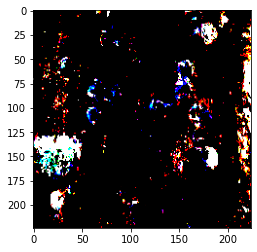

In [12]:
x,img=get_image("./muestras/test/a16-AceiteMario/SingleShot0085.jpg")
result=resize_and_rescale(img[0])
plt.imshow(img[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


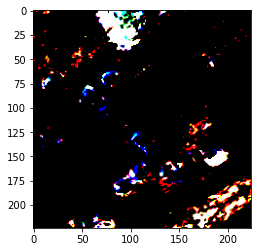

In [13]:
plt.imshow(result)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


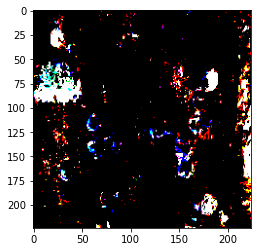

In [14]:
result_rot90 = tf.image.rot90(img[0])
result_flip_left_right=tf.image.flip_left_right(img[0])
result_flip_up_down=tf.image.flip_up_down(img[0])
plt.imshow(result_flip_up_down)

In [15]:
result == img[0]

<tf.Tensor: shape=(224, 224, 3), dtype=bool, numpy=
array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, Fa

# Data Generator

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
transformation_ratio = 0.05
train_path = "muestras/train"
test_path = "muestras/test"
datagen = ImageDataGenerator(rescale=1. / 255,
                             validation_split = 0.2,
                             rotation_range=transformation_ratio,
                             shear_range=transformation_ratio,
                             zoom_range=transformation_ratio,
                             cval=transformation_ratio,
                             horizontal_flip=True,
                             vertical_flip=True)

train_it = datagen.flow_from_directory(train_path, 
                                       target_size=(224,224), 
                                       color_mode='rgb', 
                                       class_mode="categorical",
                                       batch_size=25, #12
                                       subset = "training")

valid_it = datagen.flow_from_directory(train_path,
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=25,#12
                                     subset='validation')

datagen_test = ImageDataGenerator(rescale=1./255, rotation_range=transformation_ratio,
                             shear_range=transformation_ratio,
                             zoom_range=transformation_ratio,
                             cval=transformation_ratio,
                             horizontal_flip=True,
                             vertical_flip=True)

val_data = datagen_test.flow_from_directory(test_path, 
                                           target_size=(224, 224), 
                                           color_mode='rgb',
                                           class_mode='categorical',
                                           shuffle=False)

Found 1923 images belonging to 19 classes.
Found 475 images belonging to 19 classes.
Found 284 images belonging to 19 classes.


In [17]:
num_classes=train_it.num_classes
input_shape=(224,224,3)
labels = train_it.class_indices.keys()
labels

dict_keys(['Achapo', 'Cedro-costenio', 'Chanul', 'Cipres', 'Cuangare', 'Eucalipto-blanco', 'Guayacan-amarillo', 'Nogal-cafetero', 'Pino-patula', 'Urapan', 'a16-AceiteMario', 'a21-Palialte-Amarillo', 'aguamanil-c716', 'c715-tangare', 'c717', 'd543', 'd574-cargadero', 'd575-caimito', 'n33-pomo'])

In [18]:
# summary
print("finished loading %d images from %d categories"%(((train_it.samples)+ (valid_it.samples)+ (val_data.samples)), num_classes))
print("train / validation / test split: %d, %d, %d"%((train_it.samples), (valid_it.samples), (val_data.samples)))

finished loading 2682 images from 19 categories
train / validation / test split: 1923, 475, 284


# Optimizator

In [19]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

# First training a neural net from scratch

Before doing the transfer learning, let's first build a neural network from scratch for doing classification on our dataset. This will give us a baseline to compare to our transfer-learned network later.

The network we will construct contains 4 alternating convolutional and max-pooling layers, followed by a [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) after every other conv/pooling pair. After the last pooling layer, we will attach a fully-connected layer with 256 neurons, another dropout layer, then finally a softmax classification layer for our classes.

Our loss function will be, as usual, categorical cross-entropy loss, and our learning algorithm will be [AdaDelta](https://arxiv.org/abs/1212.5701). Various things about this network can be changed to get better performance, perhaps using a larger network or a different optimizer will help, but for the purposes of this notebook, the goal is to just get an understanding of an approximate baseline for comparison's sake, and so it isn't neccessary to spend much time trying to optimize this network.

Upon compiling the network, let's run `model.summary()` to get a snapshot of its layers.

In [98]:
# build the network
model = Sequential()
print("Input dimensions: ",(224, 224, 3))

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.34))#0.25

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.34))#0.25

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.4))#0.5

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()


Input dimensions:  (224, 224, 3)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 activation_12 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_13 (Activation)  (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                

We've created a medium-sized network with ~1.2 million weights and biases (the parameters). Most of them are leading into the one pre-softmax fully-connected layer "dense_5".

We can now go ahead and train our model for 100 epochs with a batch size of 128. We'll also record its history so we can plot the loss over time later. 

In [99]:
inicio = time.time()
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=opt, # sgdm
              metrics=['accuracy'])  # ver si se puede poner otra metrica adicional o solo recibe 1.

history = model.fit(train_it,
                    batch_size=32,#128, #32
                    epochs=60,#10
                    validation_data=valid_it,
                    steps_per_epoch=train_it.samples/train_it.batch_size,
                    validation_steps=valid_it.samples/valid_it.batch_size,
                  )
fin = time.time()
history
print("Fin",fin-inicio)

Epoch 1/60
76/76 [==============================] - 35s 450ms/step - loss: 2.9058 - accuracy: 0.1004 - val_loss: 2.8688 - val_accuracy: 0.1200
Epoch 2/60
76/76 [==============================] - 34s 442ms/step - loss: 2.8248 - accuracy: 0.1134 - val_loss: 2.8453 - val_accuracy: 0.1537
Epoch 3/60
76/76 [==============================] - 34s 443ms/step - loss: 2.8016 - accuracy: 0.1160 - val_loss: 2.8377 - val_accuracy: 0.1011
Epoch 4/60
76/76 [==============================] - 34s 444ms/step - loss: 2.7808 - accuracy: 0.1097 - val_loss: 2.8282 - val_accuracy: 0.1053
Epoch 5/60
76/76 [==============================] - 34s 440ms/step - loss: 2.7595 - accuracy: 0.1113 - val_loss: 2.8215 - val_accuracy: 0.1811
Epoch 6/60
76/76 [==============================] - 34s 443ms/step - loss: 2.7479 - accuracy: 0.1243 - val_loss: 2.8124 - val_accuracy: 0.1432
Epoch 7/60
76/76 [==============================] - 34s 438ms/step - loss: 2.7261 - accuracy: 0.1035 - val_loss: 2.7949 - val_accuracy: 0.1874

Let's plot the validation loss and validation accuracy over time.

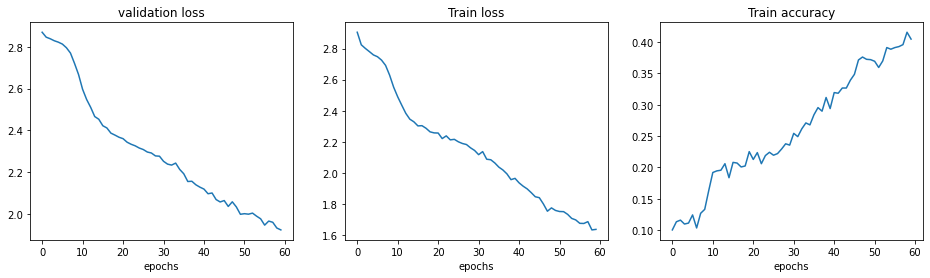

In [100]:
# history.history
# fig = plt.figure(figsize=(16,4))
fig,ax=plt.subplots(1,3)
# ax = fig.add_subplot(121)
ax[0].plot(history.history["val_loss"])
ax[0].set_title("validation loss")
ax[0].set_xlabel("epochs")

# ax2 = fig.add_subplot(122)
ax[1].plot(history.history["loss"])
ax[1].set_title("Train loss")
# ax[1].set_ylim(0, 1)
ax[1].set_xlabel("epochs")


# ax3 = fig.add_subplot(224)
ax[2].plot(history.history["accuracy"])
ax[2].set_title("Train accuracy")
ax[2].set_xlabel("epochs")
# ax3.set_ylim(0, 1)
plt.rcParams["figure.figsize"] = (16,4)
plt.show()

(0.0, 1.0)

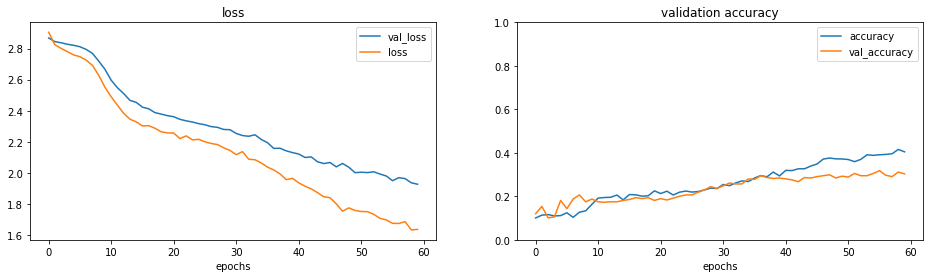

In [101]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
# ax.plot(history2.history["val_loss"])
# ax.plot(history3.history["val_loss"])
ax.plot(history.history["loss"])
ax.set_title("loss")
ax.set_xlabel("epochs")
plt.legend(['val_loss','loss'])

ax2 = fig.add_subplot(122)
ax2.plot(history.history["accuracy"])
# ax2.plot(history2.history["val_accuracy"])
# ax2.plot(history3.history["val_accuracy"])
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
plt.legend(['accuracy','val_accuracy'])
ax2.set_ylim(0, 1)

Notice that the validation loss begins to actually rise after around 16 epochs, even though validation accuracy remains roughly between 40% and 50%. This suggests our model begins overfitting around then, and best performance would have been achieved if we had stopped early around then. Nevertheless, our accuracy would not have likely been above 50%, and probably lower down.

We can also get a final evaluation by running our model on the training set. Doing so, we get the following results:

In [102]:
loss, accuracy = model.evaluate(val_data, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 2.007040023803711
Test accuracy: 0.2887323796749115


In [103]:
row=[["cnn",accuracy,loss,(fin-inicio)/60]]
stats = pd.DataFrame(row,columns=["model","test_accuracy","test_loss","tiempo_ejecucion(min)"])
stats

,model,test_accuracy,test_loss,tiempo_ejecucion(min)
0,cnn,0.288732,2.00704,33.819202


<AxesSubplot:>

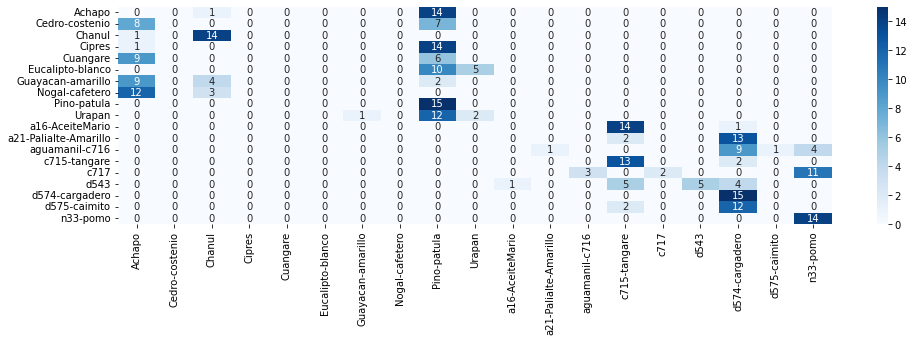

In [104]:
probabilities = model.predict(val_data)
cm=confusion_matrix(val_data.classes,probabilities.argmax(axis=1))
sns.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels,cmap='Blues')

In [105]:
img, x = get_image('SingleShot0103.jpg')
x=x.astype('float32') / 255.
probabilities_x = model.predict([x])
df = pd.DataFrame(probabilities_x,columns=train_it.class_indices.keys())
df

,Achapo,Cedro-costenio,Chanul,Cipres,Cuangare,Eucalipto-blanco,Guayacan-amarillo,Nogal-cafetero,Pino-patula,Urapan,a16-AceiteMario,a21-Palialte-Amarillo,aguamanil-c716,c715-tangare,c717,d543,d574-cargadero,d575-caimito,n33-pomo
0,0.03079,0.006917,0.302865,0.007912,0.039604,0.002112,0.006983,0.035939,0.01756,0.002128,0.091065,0.02144,0.015051,0.161302,0.012257,0.176241,0.039263,0.027451,0.003121


# MobileNet

In [20]:
# import tensorflow as tf

mobileNet=tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
mobileNet.trainable = False
print("Number of layers in the base model: ", len(mobileNet.layers))

Number of layers in the base model:  154


In [25]:
from keras import regularizers
opt_mn = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [53]:
mobileNet_model = Sequential()
mobileNet_model.add(mobileNet)
mobileNet_model.add(GlobalAveragePooling2D())
mobileNet_model.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.001)))#,kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.001)
mobileNet_model.add(Dropout(0.35))
mobileNet_model.add(Dense(num_classes, activation="softmax",))
mobileNet_model.compile(loss="categorical_crossentropy", optimizer=opt_mn,
                    metrics=["accuracy"])
len(mobileNet_model.trainable_variables)

58

In [54]:
print("Number of layers in the base model: ", len(mobileNet.layers))
mobileNet.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobileNet.layers[:fine_tune_at]:
  layer.trainable = False
len(mobileNet_model.trainable_variables)

Number of layers in the base model:  154


58

In [55]:
inicio = time.time()
history4 = mobileNet_model.fit(train_it, 
                         batch_size=32,#45, 32
                         epochs=60,#10 
                         validation_data=valid_it)
fin = time.time()
print(fin-inicio)

Epoch 1/60
77/77 [==============================] - 40s 482ms/step - loss: 15.8403 - accuracy: 0.9402 - val_loss: 12.1473 - val_accuracy: 0.8968
Epoch 2/60
77/77 [==============================] - 35s 461ms/step - loss: 8.9605 - accuracy: 0.9932 - val_loss: 7.1669 - val_accuracy: 0.9074
Epoch 3/60
77/77 [==============================] - 36s 465ms/step - loss: 5.2685 - accuracy: 0.9906 - val_loss: 4.5045 - val_accuracy: 0.9011
Epoch 4/60
77/77 [==============================] - 36s 463ms/step - loss: 3.1948 - accuracy: 0.9917 - val_loss: 2.8224 - val_accuracy: 0.8968
Epoch 5/60
77/77 [==============================] - 36s 464ms/step - loss: 1.9715 - accuracy: 0.9943 - val_loss: 1.8470 - val_accuracy: 0.9095
Epoch 6/60
77/77 [==============================] - 36s 463ms/step - loss: 1.2830 - accuracy: 0.9932 - val_loss: 1.3146 - val_accuracy: 0.9368
Epoch 7/60
77/77 [==============================] - 36s 465ms/step - loss: 0.8921 - accuracy: 0.9932 - val_loss: 1.0226 - val_accuracy: 0.92

(0.0, 1.0)

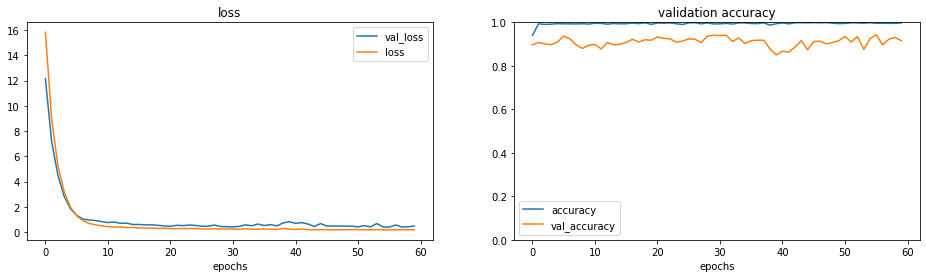

In [57]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history4.history["val_loss"])
# ax.plot(history2.history["val_loss"])
# ax.plot(history3.history["val_loss"])
ax.plot(history4.history["loss"])
ax.set_title("loss")
ax.set_xlabel("epochs")
plt.legend(['val_loss','loss'])

ax2 = fig.add_subplot(122)
ax2.plot(history4.history["accuracy"])
# ax2.plot(history2.history["val_accuracy"])
# ax2.plot(history3.history["val_accuracy"])
ax2.plot(history4.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
plt.legend(['accuracy','val_accuracy'])
ax2.set_ylim(0, 1)

In [56]:
loss, accuracy= mobileNet_model.evaluate(val_data, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.5976178646087646
Test accuracy: 0.9119718074798584


<AxesSubplot:>

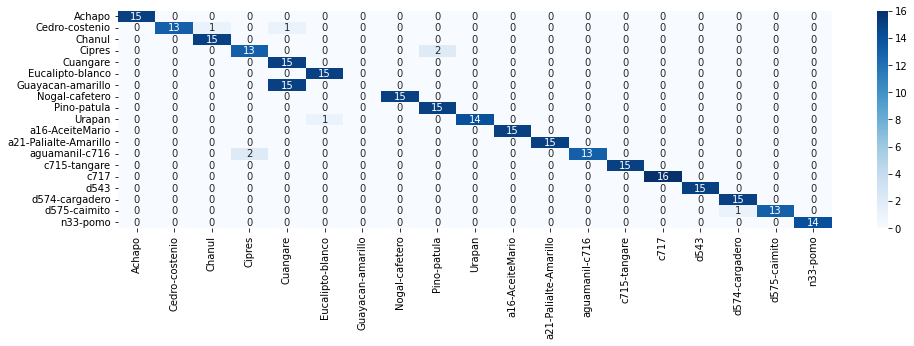

In [60]:
probabilities = mobileNet_model.predict(val_data)
df = pd.DataFrame(probabilities,columns=train_it.class_indices.keys())
#df
cm=confusion_matrix(val_data.classes,probabilities.argmax(axis=1))

sns.heatmap(cm, annot=True,xticklabels=train_it.class_indices.keys(),yticklabels=train_it.class_indices.keys(),cmap='Blues')

In [113]:
img, x = get_image('SingleShot0103.jpg')
x=x.astype('float32') / 255.
probabilities_x = mobileNet_model.predict([x])
df = pd.DataFrame(probabilities_x,columns=train_it.class_indices.keys())
df

,Achapo,Cedro-costenio,Chanul,Cipres,Cuangare,Eucalipto-blanco,Guayacan-amarillo,Nogal-cafetero,Pino-patula,Urapan,a16-AceiteMario,a21-Palialte-Amarillo,aguamanil-c716,c715-tangare,c717,d543,d574-cargadero,d575-caimito,n33-pomo
0,0.000284,0.000756,0.000162,0.000009,0.000108,0.003945,0.000108,0.000548,0.000004,0.001546,0.972885,0.00006,0.000007,0.016548,0.001727,0.000007,0.000057,0.000134,0.001105


In [114]:
row=["MobileNet",accuracy,loss,(fin-inicio)/60]
stats.loc[1]= row
stats

,model,test_accuracy,test_loss,tiempo_ejecucion(min)
0,cnn,0.288732,2.007040,33.819202
1,MobileNet,0.827465,0.646193,33.870233


# Vgg16

In [115]:
# import tensorflow as tf
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [116]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


In [117]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_new.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [118]:
inicio = time.time()
history2 = model_new.fit(train_it, 
                         batch_size=125,#45, 32
                         epochs=60,#10 
                         validation_data=valid_it)
fin = time.time()
print(fin-inicio)

Epoch 1/60
77/77 [==============================] - 35s 451ms/step - loss: 2.8779 - accuracy: 0.1019 - val_loss: 2.7832 - val_accuracy: 0.1368
Epoch 2/60
77/77 [==============================] - 35s 450ms/step - loss: 2.6969 - accuracy: 0.1492 - val_loss: 2.6840 - val_accuracy: 0.1389
Epoch 3/60
77/77 [==============================] - 34s 444ms/step - loss: 2.5990 - accuracy: 0.1799 - val_loss: 2.6050 - val_accuracy: 0.2084
Epoch 4/60
77/77 [==============================] - 35s 450ms/step - loss: 2.5287 - accuracy: 0.2153 - val_loss: 2.5443 - val_accuracy: 0.2189
Epoch 5/60
77/77 [==============================] - 34s 445ms/step - loss: 2.4692 - accuracy: 0.2569 - val_loss: 2.4884 - val_accuracy: 0.2421
Epoch 6/60
77/77 [==============================] - 35s 455ms/step - loss: 2.4129 - accuracy: 0.2819 - val_loss: 2.4447 - val_accuracy: 0.2253
Epoch 7/60
77/77 [==============================] - 34s 447ms/step - loss: 2.3647 - accuracy: 0.2933 - val_loss: 2.3927 - val_accuracy: 0.2442

Our validation accuracy hovers close to 80% towards the end, which is more than 30% improvement on the original network trained from scratch (meaning that we make the wrong prediction on 20% of samples, rather than 50%). 

It's worth noting also that this network actually trains _slightly faster_ than the original network, despite having more than 100 times as many parameters! This is because freezing the weights negates the need to backpropagate through all those layers, saving us on runtime.

Let's plot the validation loss and accuracy again, this time comparing the original model trained from scratch (in blue) and the new transfer-learned model in green.

(0.0, 1.0)

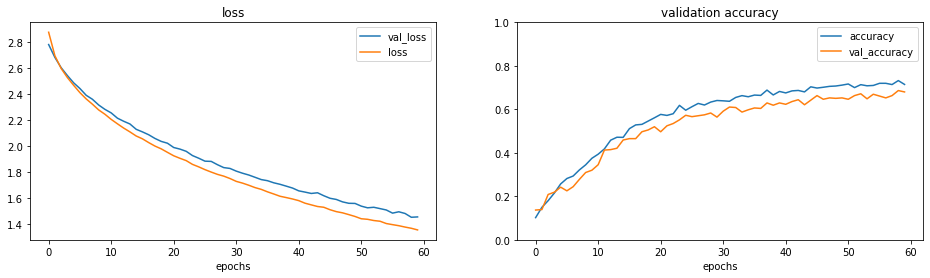

In [119]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["val_loss"])
# ax.plot(history2.history["val_loss"])
# ax.plot(history3.history["val_loss"])
ax.plot(history2.history["loss"])
ax.set_title("loss")
ax.set_xlabel("epochs")
plt.legend(['val_loss','loss'])

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["accuracy"])
# ax2.plot(history2.history["val_accuracy"])
# ax2.plot(history3.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
plt.legend(['accuracy','val_accuracy'])
ax2.set_ylim(0, 1)

Notice that whereas the original model began overfitting around epoch 16, the new model continued to slowly decrease its loss over time, and likely would have improved its accuracy slightly with more iterations. The new model made it to roughly 80% top-1 accuracy (in the validation set) and continued to improve slowly through 100 epochs.

It's possibly we could have improved the original model with better regularization or more dropout, but we surely would not have made up the >30% improvement in accuracy. 

Again, we do a final validation on the test set.

In [120]:
loss, accuracy= model_new.evaluate(val_data, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)
# print("test recall",recall)
# print('test precision',Precision)

Test loss: 1.57191801071167
Test accuracy: 0.6197183132171631


In [121]:
row=["VGG16",accuracy,loss,(fin-inicio)/60]
stats.loc[2]= row
stats

,model,test_accuracy,test_loss,tiempo_ejecucion(min)
0,cnn,0.288732,2.007040,33.819202
1,MobileNet,0.827465,0.646193,33.870233
2,VGG16,0.619718,1.571918,34.459719


To predict a new image, simply run the following code to get the probabilities for each class.

<AxesSubplot:>

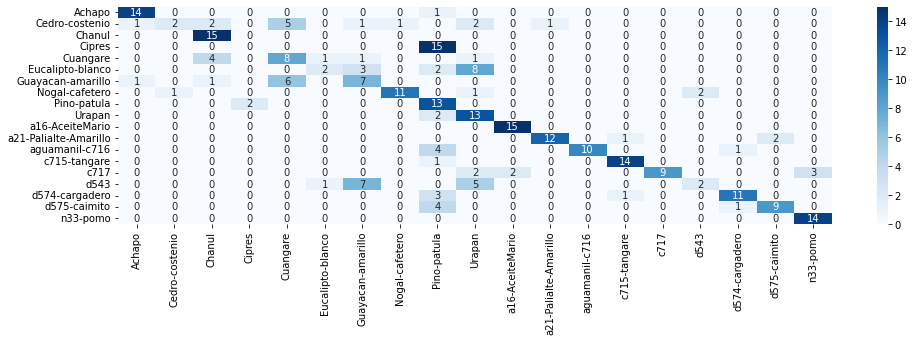

In [122]:
# img, x = get_image('3.jpg')
# print(x_test)
probabilities = model_new.predict(val_data)
df = pd.DataFrame(probabilities,columns=labels)
#df
cm=confusion_matrix(val_data.classes,probabilities.argmax(axis=1))

sns.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels,cmap='Blues')

In [123]:
img, x = get_image('SingleShot0103.jpg')
x=x.astype('float32') / 255.
probabilities_x = model_new.predict([x])
df = pd.DataFrame(probabilities_x,columns=labels)
df

,Achapo,Cedro-costenio,Chanul,Cipres,Cuangare,Eucalipto-blanco,Guayacan-amarillo,Nogal-cafetero,Pino-patula,Urapan,a16-AceiteMario,a21-Palialte-Amarillo,aguamanil-c716,c715-tangare,c717,d543,d574-cargadero,d575-caimito,n33-pomo
0,0.061472,0.043776,0.041018,0.006518,0.051839,0.067429,0.055952,0.029758,0.017128,0.079876,0.245998,0.031169,0.014694,0.024332,0.073529,0.019759,0.03501,0.063341,0.037401


# ResNet 50

In [61]:
pretrained_model= tf.keras.applications.ResNet50V2(input_shape=input_shape, weights='imagenet',include_top=False)
pretrained_model.trainable = False
print("Number of layers in the base model: ", len(pretrained_model.layers))

Number of layers in the base model:  190


In [85]:
resnet_model = Sequential()
resnet_model.add(pretrained_model)
resnet_model.add(GlobalAveragePooling2D())
# resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.001)))
mobileNet_model.add(Dropout(0.2))
resnet_model.add(Dense(num_classes, activation='softmax'))
resnet_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_18  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_35 (Dense)            (None, 512)               1049088   
                                                                 
 dense_36 (Dense)            (None, 19)                9747      
                                                                 
Total params: 24,623,635
Trainable params: 18,266,131
Non-trainable params: 6,357,504
_________________________________________________________________


In [86]:
from keras import regularizers
opt_rn = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [87]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=opt_rn,
              # optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              # optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=['accuracy'],)

In [88]:
print("Number of layers in the base model: ", len(pretrained_model.layers))
pretrained_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 130

# Freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_model.layers[:fine_tune_at]:
  layer.trainable = False
len(resnet_model.trainable_variables)

Number of layers in the base model:  190


58

In [89]:
inicio = time.time()
history2 = resnet_model.fit(train_it, 
                         batch_size=32,#45, 32
                         epochs=60,#10 
                         validation_data=valid_it)
fin = time.time()
print(fin-inicio)

Epoch 1/60
77/77 [==============================] - 41s 486ms/step - loss: 24.4416 - accuracy: 0.9501 - val_loss: 22.5947 - val_accuracy: 0.8968
Epoch 2/60
77/77 [==============================] - 36s 468ms/step - loss: 19.9146 - accuracy: 0.9948 - val_loss: 18.3079 - val_accuracy: 0.8821
Epoch 3/60
77/77 [==============================] - 36s 472ms/step - loss: 15.7635 - accuracy: 0.9974 - val_loss: 14.4245 - val_accuracy: 0.9011
Epoch 4/60
77/77 [==============================] - 36s 468ms/step - loss: 12.1106 - accuracy: 0.9943 - val_loss: 10.9422 - val_accuracy: 0.9032
Epoch 5/60
77/77 [==============================] - 36s 467ms/step - loss: 9.0387 - accuracy: 0.9938 - val_loss: 8.3484 - val_accuracy: 0.8842
Epoch 6/60
77/77 [==============================] - 36s 469ms/step - loss: 6.6320 - accuracy: 0.9948 - val_loss: 6.1923 - val_accuracy: 0.8905
Epoch 7/60
77/77 [==============================] - 36s 467ms/step - loss: 4.8794 - accuracy: 0.9964 - val_loss: 4.7198 - val_accuracy

(0.0, 1.0)

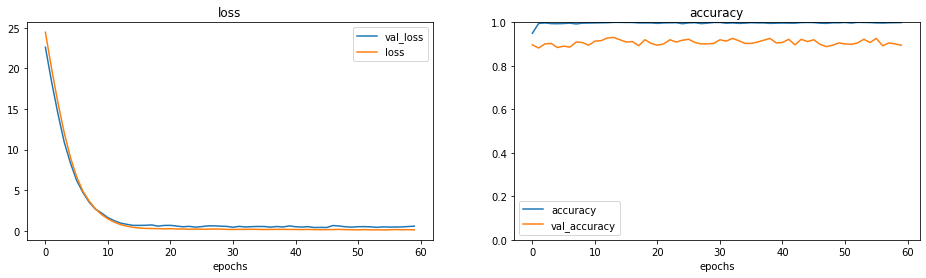

In [90]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["val_loss"])
ax.plot(history2.history["loss"])
ax.set_title("loss")
ax.set_xlabel("epochs")
plt.legend(['val_loss', 'loss'])

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("accuracy")
ax2.set_xlabel("epochs")
plt.legend(['accuracy', 'val_accuracy'])
ax2.set_ylim(0, 1)

In [92]:
loss, accuracy= resnet_model.evaluate(val_data, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.7365126013755798
Test accuracy: 0.8943662047386169


In [131]:
row=["ResNet50",accuracy,loss,(fin-inicio)/60]
stats.loc[3]= row
stats

,model,test_accuracy,test_loss,tiempo_ejecucion(min)
0,cnn,0.288732,2.007040,33.819202
1,MobileNet,0.827465,0.646193,33.870233
2,VGG16,0.619718,1.571918,34.459719
3,ResNet50,0.841549,0.684220,34.169481


In [132]:
stats["Optimizer"] = opt.lr.numpy()
stats

,model,test_accuracy,test_loss,tiempo_ejecucion(min),Optimizer
0,cnn,0.288732,2.007040,33.819202,0.00001
1,MobileNet,0.827465,0.646193,33.870233,0.00001
2,VGG16,0.619718,1.571918,34.459719,0.00001
3,ResNet50,0.841549,0.684220,34.169481,0.00001


In [133]:
stats.to_csv("stats.csv")

<AxesSubplot:>

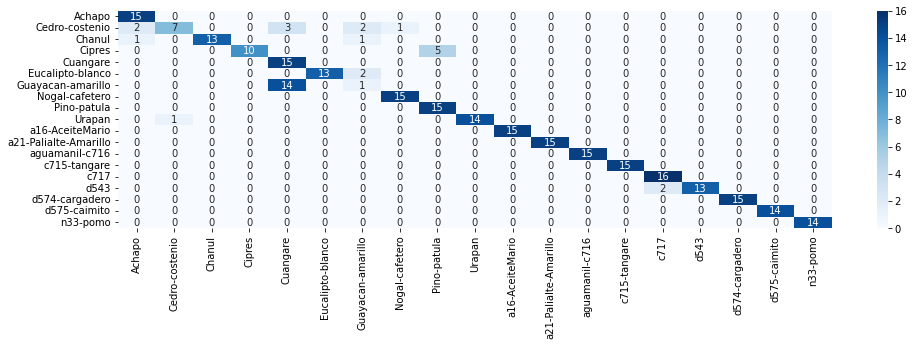

In [93]:
# img, x = get_image('3.jpg')
# print(x_test)
probabilities = resnet_model.predict(val_data)
df = pd.DataFrame(probabilities,columns=labels)
#df
cm=confusion_matrix(val_data.classes,probabilities.argmax(axis=1))

sns.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels,cmap='Blues')

In [2]:
img, x = get_image('SingleShot0103.jpg')
x=x.astype('float32') / 255.
probabilities_x = resnet_model.predict([x])
df = pd.DataFrame(probabilities_x,columns=labels)
df

NameError: name 'get_image' is not defined

In [ ]:
# resnet_model.save("model_resnet_06022022.h5")
# model_new.save_weights('weights_resnet')

# EfficientNet


In [ ]:
base_model =  tf.keras.applications.efficientnet_v2.EfficientNetV2B0(weights = 'imagenet', include_top = False, input_shape=input_shape)
# Adding a global spatial average pooling layer
base_model.trainable = False
# x = base_model.output
# x = GlobalAveragePooling2D()(x)

# #Adding a fully-connected dense layer
# x = Dense(512, activation='relu')(x)
# predictions = Dense(num_classes, activation="softmax")(x)#.layers[-2].output
# efn_model = Model(inputs = base_model.input, outputs = predictions)
# # efn_model.summary()
# len(efn_model.trainable_variables)

24289280/24274472 [==============================] - 1s 0us/step


In [ ]:
efficientNet_model = Sequential()
efficientNet_model.add(base_model)
efficientNet_model.add(GlobalAveragePooling2D())
efficientNet_model.add(Dense(512, activation='relu'))
efficientNet_model.add(Dense(num_classes, activation="softmax"))
efficientNet_model.compile(loss="categorical_crossentropy", optimizer="adam",
                    metrics=["accuracy"])
len(efficientNet_model.trainable_variables)

4

In [ ]:
lr=random.choice((1e-2, 1e-3, 1e-4, 1e-5))
efficientNet_model.compile(loss="categorical_crossentropy", optimizer="adam",
                    metrics=["accuracy"])
lr

0.0001

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 177

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
len(efficientNet_model.trainable_variables)

Number of layers in the base model:  255


77

In [ ]:
inicio = time.time()
history3 = efficientNet_model.fit(train_it, 
                         batch_size=32,#45, 32
                         epochs=60,#10 
                         validation_data=valid_it)
fin = time.time()
print(fin-inicio)

Epoch 1/60
85/85 [==============================] - 35s 322ms/step - loss: 2.6968 - accuracy: 0.0813 - val_loss: 2.6393 - val_accuracy: 0.1440
Epoch 2/60
85/85 [==============================] - 25s 293ms/step - loss: 2.6407 - accuracy: 0.0793 - val_loss: 2.6317 - val_accuracy: 0.0800
Epoch 3/60
85/85 [==============================] - 24s 283ms/step - loss: 2.6340 - accuracy: 0.0852 - val_loss: 2.6283 - val_accuracy: 0.0800
Epoch 4/60
85/85 [==============================] - 24s 284ms/step - loss: 2.6241 - accuracy: 0.0793 - val_loss: 2.6277 - val_accuracy: 0.0800
Epoch 5/60
85/85 [==============================] - 24s 284ms/step - loss: 2.6171 - accuracy: 0.0882 - val_loss: 2.6025 - val_accuracy: 0.0800
Epoch 6/60
85/85 [==============================] - 24s 281ms/step - loss: 2.6013 - accuracy: 0.0852 - val_loss: 2.5930 - val_accuracy: 0.0800
Epoch 7/60
24/85 [=======>......................] - ETA: 13s - loss: 2.5966 - accuracy: 0.0722

(0.0, 1.0)

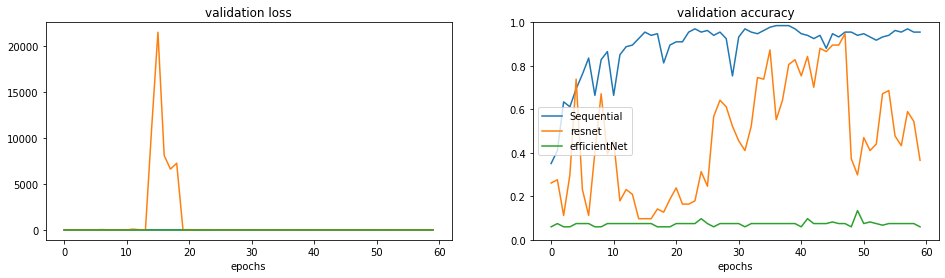

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.plot(history3.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.plot(history3.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
plt.legend(['Sequential', 'resnet',"efficientNet"])
ax2.set_ylim(0, 1)

In [1]:
loss, accuracy= efficientNet_model.evaluate(val_data, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

NameError: name 'efficientNet_model' is not defined